# Método de Montecarlo para _cliff walking_

[**Juan Gómez Romero**](https://decsai.ugr.es/~jgomez)  
Departamento de Ciencias de la Computación e Inteligencia Artificial  
Universidad de Granada  
This work is licensed under the [GNU General Public License v3.0](https://choosealicense.com/licenses/gpl-3.0/).

---

Ejemplo basado en:
> R.S. Sutton, A.G. Barto (2018) Reinforcement Learning. Chapters 6.5: Q-learning: Off-policy TD Control, 6.6: Expected Sarsa.

_Consider the gridworld shown to the right. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is -1 on all transitions except those into the region marked "The Cliff" Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start._

![](cliffwalking.png)

> Udacity (2019) Deep Reinforcement Learning Course. Available in [GitHub](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py).

## Explorar entorno virtual

En este ejercicio utilizamos el entorno virtual [CliffWalking-v0](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) de [OpenAI](https://openai.com). 

En primer lugar, vamos a explorar cómo funciona este entorno.

In [1]:
import gym

Crear entorno:

In [2]:
env = gym.make('CliffWalking-v0')

El estado es la posición que ocupa el agente en la cuadrícula, numerada del $0$ al $47$.

El estado inicial es la posición $36$. La posición $47$ es el estado final. 

El agente puede realizar 4 acciones:

```
    ARRIBA = 0
    DERECHA = 1
    ABAJO = 2
    IZQUIERDA = 3
```

En [CliffWalking-v0](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) la recompensa es siempre $-1$, excepto cuando se cae al precipicio ($-100$). No obstante, el rango definido de posibles recompensas es $[-\inf, +\inf]$. 

El objetivo del agente es alcanzar la posición final en el menor tiempo posible. El episodio termina cuando el agente encuentra la meta o cae al precipicio.

In [3]:
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Discrete(48)
Discrete(4)
(-inf, inf)


El siguiente código implementa un agente aleatorio (actúa durante 10 episodios).

In [4]:
for i_episode in range(10):
    state = env.reset()
    acc_reward = 0
    while True:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        acc_reward += reward
        if done:
            print('\nMeta alcanzada :)') if reward < -100 else print('\nCaiste :(') 
            print('Recompensa: ', acc_reward)            
            break

env.close()


Caiste :(
Recompensa:  -6940

Caiste :(
Recompensa:  -23560

Caiste :(
Recompensa:  -16512

Caiste :(
Recompensa:  -166702

Caiste :(
Recompensa:  -47673

Caiste :(
Recompensa:  -5783

Caiste :(
Recompensa:  -121673

Caiste :(
Recompensa:  -5290

Caiste :(
Recompensa:  -3514

Caiste :(
Recompensa:  -24713


Como cabría esperar, el agente no es muy efectivo y cae al precipicio en la mayoría de las ocasiones.

# Método de Montecarlo

### Algoritmo
A continuación se proporciona una implementación del algoritmo de Montecarlo genérica para entornos con especios de estados y acciones discretos.

In [5]:
import sys
import gym
import numpy as np
from collections import defaultdict

def generate_episode_from_Q_epsilon(env, Q, epsilon, limit=1000):
    """Generador de episodios:
    Params
    ======
    env: entorno discreto
    Q: tabla Q, definida como un diccionario Q[state][action] = reward
    epsilon: valor para epsilon-greedy"""
    
    episode = []
    state = env.reset()
    while True:
        r = np.random.uniform(size=1)[0]
        if r <= epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])                
        
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
        if done or len(episode) > limit:
            break
            
    return episode

def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0, epsilon=0.2):
    """Algoritmo de Montecarlo:
    Params
    ======
    env: entorno discreto
    num_episodes: numero de episodios a generar
    generate_episode: funcion para generar episodio siguiente
    gamma: tasa de descuento
    epsilon: valor para epsilon-greedy"""

    # inicializar diccionarios (prediccion every-visit)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Q
    N = defaultdict(lambda: np.zeros(env.action_space.n))  # numero de visitas a (estado, accion)
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n)) # suma de recompensa en (estado, accion)
    
    # bucle de episodios
    for i_episode in range(1, num_episodes+1):
        
        # monitorizar progreso
        if i_episode % 1 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # generar episodio
        episode = generate_episode(env, Q, epsilon)
        
        # actualizar tabla Q
        # - obtener estados, acciones y recompensas del episodio
        states, actions, rewards = zip(*episode)        
        # - obtener gamma para aplicar descuentos
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # - actualizar suma de recompensa, numero de visitas y Q para cada (estado, accion) del episodio        
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
            
    return Q, policy

Para llamar al algoritmo, creamos el entorno y llamamos a la función `mc_prediction_q`. 

In [6]:
env = gym.make('CliffWalking-v0')

# obtener estimacion de Q (funcion accion-valor)
Q, policy = mc_prediction_q(env, 20000, generate_episode_from_Q_epsilon)

Episode 20000/20000.

### Visualización de resultados
Podemos ver la política que se ha obtenido tras aplicar el método.

In [7]:
# Mostrar política como matriz
policy_plot = np.array([policy[key] if key in policy else -1 for key in np.arange(48)]).reshape(4, 12)
print("\nPolitica optima estimada(ARRIBA = 0, DERECHA = 1, ABAJO = 2, IZQUIERDA = 3, N/A = -1):")
print(policy_plot)


Politica optima estimada(ARRIBA = 0, DERECHA = 1, ABAJO = 2, IZQUIERDA = 3, N/A = -1):
[[ 1  1  1  1  2  1  1  1  1  1  2  2]
 [ 0  2  0  0  1  1  0  0  2  1  1  2]
 [ 0  3  3  1  1  1  0  3  1  0  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


También podemos representar gráficamente el valor de cada estado _(posición)_ según la estimación que hemos hecho de `Q`. 

Para visualizar los resultados es necesario disponer del fichero [_plot_\__utils.py_](https://github.com/jgromero/eci2019-DRL/blob/master/Tema%203%20-%20Aprendizaje%20por%20Refuerzo/code/plot_utils.py). 

(En Google Colaboratory, usar en el panel izquierdo, pestaña _Archivos_ > _Subir_. El fichero estará disponible hasta que se cierre el entorno de ejecución.)

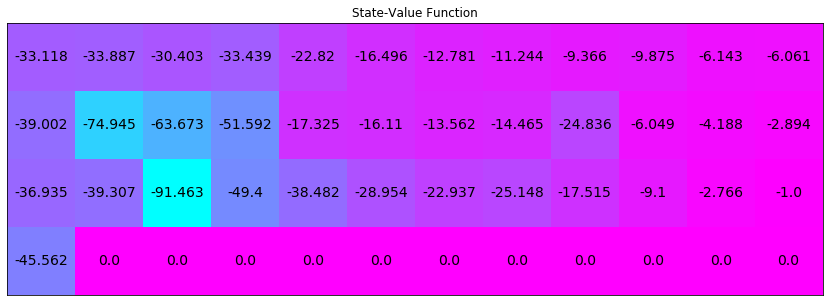

In [9]:
from plot_utils import plot_values
V = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])
plot_values(V)

---
### EJERCICIO

¿Qué parámetros influyen en el rendimiento del agente? Probar con diferentes combinaciones de valores.


---